# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

In [491]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [492]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

## 2.1 데이터 전처리 - 데이터 정제

In [493]:
## 정제 전
print(df_train.shape, df_test.shape)

(59299, 29) (5271, 30)


In [494]:
## 복제된 행 제거
df_train.drop_duplicates(inplace=True)

In [495]:
# 무조건 converted하면서 test에 없는 회사인 25096은 삭제
del_cus_id=[25096]
df_train=df_train[~df_train["customer_idx"].isin(del_cus_id)]

In [496]:
df_train.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_country.1', 'customer_position',
       'response_corporate', 'expected_timeline', 'ver_cus', 'ver_pro',
       'ver_win_rate_x', 'ver_win_ratio_per_bu', 'business_area',
       'business_subarea', 'lead_owner', 'is_converted'],
      dtype='object')

### 2.1.1 오타 제어(customer_country --> 완벽하게)

In [497]:
## 2. customer_country 오타 제어 함수
def extract_country_name(x):
    if pd.isnull(x):
        return 0
    else:
        idx=-1
        a = x.split("/")[idx].strip()
        while a=='':
            idx-=1
            if idx == -4 :
                return 0
            a = x.split("/")[idx].strip()
        if idx != -1:
            if a in ['Richmond Hill', 'Vancouver', 'Pickering', 'Winnipeg']:
                return 'Canada'
            elif a in ['ROURKELA', 'Guna mp', 'MADURAI', 'KOLKATA', 'Ahmedabad', 'Madurai'
                       'Mathura', 'Delhi', 'Solan', 'Bengaluru', 'Kanchipuram', 'Erode',
                       'NEARAMBEDKAR HOSPET', 'Bhubaneswar', 'LATEHAR', 'Malur', 'Ackerman',
                       'Faridabad', 'Vasal', 'Ballia', 'Ludhiana', 'Rajkot']:
                return 'India'
            elif a in ['Bergdietikon']:
                return 'Switzerland' 
            elif a in ['Lagos, Nigeria', 'Ikoyi', 'Abuja', 'Windhoek']:
                return 'Nigeria'
            elif a in ['Monrovia']:
                return 'Liberia'
            elif a in ['Malvern', 'Cambridge', 'Danbury', 'Dundee', 'Boulder', 'Liverpool', 'Winston']:
                return 'United Kingdom'
            elif a in ['San Jose', 'Bulacan', 'Makati City', 'Manila', 'Cebu', 'Pasig', 
                       'CALOOCAN CITY', 'dasmarinas city', 'Mandaluyong City','Angeles' 'makati', 'Angeles City',
                        'Bataan', 'TAYTAY', 'Las Piñas - Muntinlupa', 'Quezon City' ,'Valenzuela City',
                        '314 G. Araneta Ave., Quezon City', 'PASIG CITY', 'Manila', 'San Fernando City, La Union', 'Valenzuela'
                        'CAINTA', 'Quezon City', 'Camarines Sur', 'Mandaluyong', 'San Juan city', 'Qc', 'Meycauayan City, Bulacan',
                        'Parañaque','Rizal', 'Makati city', 'CITY OF IMUS', 'laGrange', 'Sanford', 'Chilhowie', 'Chesterfield', 'Amherst',
                        'Paranaque', 'Cavite', 'CITY OF MARIKINA', 'Bocaue, Bukacan, Philippines']:
                return 'Philippines'
            elif a in ['Atlanta', 'Tbilisi'] :
                return "Georgia"
            elif a in ['Oslo']:
                return 'Norway'
            elif a in ['Arroyo Hondo Viejo'] :
                return 'Dominican Republic'
            elif a in ['Midrand']:
                return 'South Africa'
            elif a in ['Olsztyn', 'Przemysłowa 4, 37-450 Stalowa Wola']:
                return "Poland"
            elif a in ['San Juan']:
                return 'Puerto Rico'
            elif a in ['Berlin', 'Weikersheim', 'Herdwangen-Schönach']:
                return 'Germany'
            elif a in ['Nassau']:
                return 'Bahamas'
            elif a in ['Sapphire', "Mission Hills", 'North Haven', 'Melbourne']:
                return 'Australia'
            elif a in ['Madrid, Spain', 'Madrid', 'Barrio Viejo De Callosa De Segura']:
                return 'Spain'
            elif a in ['Kuwait city'] :
                return 'Kuwait'
            elif a in ['Esch-sur-Alzette']:
                return 'Luxembourg'
            elif a in ['Tashkent']:
                return 'Uzbekistan'
            elif a in ['Taipei city']:
                return 'Taiwan'
            elif a in ['Tokyo']:
                return 'Japan'
            elif a in ['Thai Binh', 'Hai Duong']:
                return 'Vietnam'
            elif a in ['Buengkum']:
                return 'Thailand'
            elif a in ['Gardabaer']:
                return 'Iceland'
            elif a in ['Riyadh', "Makkah", 'Riyadh'] :
                return 'Saudi Arabia'
            elif a in ['Králův Dvůr Levín']:
                return 'Czech Republic'
            elif a in ['Cairo', 'Bloch']:
                return 'Egypt'
            elif a in ['Maseru']:
                return 'Lesotho'
            elif a in ['Colombo 03']:
                return 'Sri Lanka'
            elif a in ["Tirana"]:
                return 'Albania'
            elif a in ['70']:
                return 0
            elif a in ['Jakarta'] :
                return 'Indonesia'
            elif a in ['Paramaribo'] :
                return 'Suriname'
            elif a in ['Kampala']:
                return 'Uganda'
            elif a in ['DUBAI', 'Dubai']:
                return 'U.A.E.'
            elif a in ['Paradera']:
                return 'Aruba'
            elif a in ['上海', 'Shenzhen']:
                return 'China'
            elif a in ['Suva']:
                return 'Fiji'
            elif a in ['Budapest']:
                return 'Hungary'
            elif a in ['Amman']:
                return 'Jordan'
            elif a in ['QURUM']:
                return 'Oman'
            else:
                return 'United States'
        if a in ['5555', '48201', 'country', 'A'] :
            return 0 
        elif '@' in a:
            return 0
        else:
            return a


In [498]:
def cus_cty(df) :
  replace_values = {'US' : 'United States',
                    '700 Patroon Creek BlvdAlbanyNY12206' : 'United States',
                    '239 Court St, Brooklyn, NY 11201, United States' : 'United States',
                    'Little Rock, Arkansas, United States' : 'United States',
                    'CA 91915-6002' : 'United States',
                    '430 N Hamilton RdWhitehall, OH 43213, USA' : 'United States',
                    '1110 Morse Rd, Columbus, Ohio, 43229, United States' : 'United States',
                    '1755 North Brown Rd. Suite 200 Lawrenceville, GA 30043' : 'United States',
                    'Miami, Florida, United States' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501' : 'United States',
                    '85 W Main St Suite C, Canton, GA 30114' : 'United States',
                    '101 MetLife Way, Cary, NC, 27513 – MET1' : 'United States',
                    '7105 Northland Terrace N, Minneapolis, MN 55428' : 'United States',
                    'CA 95814' : 'United States',
                    '1275 Sister Grove Rd Van Alstyne, TX 75495' : 'United States',
                    '100 Vestavia ParkwayBirminghamAL35216' : 'United States',
                    'CA 92618 United States' : 'United States',
                    'Rio de Janeiro' : 'Brazil',
                    '1605 Ave. Ponce de León, Suite 400 San Juan, 00909, Puerto Rico' : 'Puerto Rico',
                    'IL 60069' : 'United States',
                    '28001 238th St, Le Claire, IA 52753, USA' : 'United States',
                    'Grapevine, Texas, United States United States' : 'United States',
                    '700 District Dr, Itasca, IL 60143 United States' : 'United States',
                    '6398 College Blvd, Overland Park, KS 66211, United States' : 'United States',
                    '3804 W Broadway St, Ardmore, OK 73401, United States' : 'United States',
                    'New York City Metropolitan Area, United States': 'United States',
                    '2529 W Busch Blvd Suite 1000, Tampa, FL 33618, United States' : 'United States',
                    '1100 ITBProvoUT84602' : 'United States',
                    'Telangana' : 'India',
                    'Jeffersonville, IN United States' : 'United States',
                    '6564 Headquarters DrPlanoTX7505' : 'United States',
                    '1817 S Washington AveTitusville, FL 32780, USA' : 'United States',
                    '63 Flushing Ave Bldg 303, Suite 804, Brooklyn, NY 11205, United States' : 'United States',
                    '717 General Booth BlvdVirginia Beach, VA 23451, USA' : 'United States',
                    '2877 Prospect Rd, Fort Lauderdale, FL 33309' : 'United States',
                    'bangalore' : 'India',
                    'MI 48827' : 'United States',
                    '810 N KINGSTON DR PEORIA, IL 61604-2145' : 'United States',
                    'OH 45215, USA' : 'United States',
                    '3801 E Willow St, Long Beach, CA 90815, EE. UU.' : 'United States',
                    'Clinton, OK 73601' : 'United States',
                    'Ha Noi' : 'Vietnam',
                    'ARGENTINA' : 'Argentina',
                    '3100 Shore Drive Virginia Beach, VA 23451' : 'United States',
                    'Los Angeles, California, United States' : 'United States',
                    'West Caldwell NJ 07960 United States' : 'United States',
                    '881 S Division St, Buffalo, NY 14210, United States' : 'United States',
                    '12718 Kitten Trail, Hudson, FL 34669' : 'United States',
                    'FL 33772' : 'United States',
                    '13351 Dovers St, Waverly, NE 68462, United States' : 'United States',
                    'Jacksonville Florida' : 'United States',
                    'Ohio United States' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501' : 'United States',
                    '6564 Headquarters DrPlanoTX75051' : 'United States',
                    'RJ' : 'Brazil',
                    'TX 78572 United States' : 'United States',
                    '117 Bernal Rd Ste70-422San JoseSan JoseCA95119 ' : 'United States',
                    '993 Niagara Ave, San Diego, CA 92107 United States' : 'United States',
                    'Four Embarcadero Center Suite 1400 #85, San Francisco, CA 94111 United States' : 'United States',
                    'odisha' : 'India',
                    'lucknow' : 'India',
                    '1036 n nalder st' : 'United States',
                    'United States 32901' : 'United States',
                    '2100 Engineer Rd, Oakland, CA 94607, United States' : 'United States',
                    'Via E. De Amicis, 23 . 90044 Carini (PA)' : 'Italy',
                    '136 S IndustrialSalineMI48176' : 'United States',
                    '335 League St S, Sulphur Springs, TX 75482' : 'United States',
                    'United States 14503.' : 'United States',
                    'gurgaon' : 'India',
                    '30 Winter Street Boston, MA 02108' : 'United States',
                    '275 John Hancock Rd. Taunton, MA, 02780' : 'United States',
                    'MA 02062 United States' : 'United States',
                    'Pune' : 'India',
                    'FL 33025' : 'United States',
                    'Bari, Italy' : 'Italy',
                    '8 Gay St, Christiana, PA 17509 United States' : 'United States', # 게이 뭐노 ㅋ,
                    '500 N Highway 89 North, Prescott AZ 86313 United States' : 'United States',
                    '609 Medical Center Dr. Decatur, Texas, 76234'  : 'United States',
                    '7703 Floyd Curl Dr MC 7800, San Antonio TX 78229 United States' : 'United States',
                    'St Cloud, MN 56303' : 'United States',
                    '7581 S Franklin Way, Centennial, CO 80122, United States' : 'United States',
                    # '' : 'United States',
                    'Honduras' : 'Honduras',
                    'CARRERA 11A 94-46 EDIFICIO CHICO 3000 PISO 3 BOGOTA' : 'Colombia',
                    'Netherlands Antilles' : 'Netherlands',
                    '823 Gateway Center Way, San Diego, CA 92102' : 'United States',
                    'Colombia  Cartagena' : 'Colombia',
                    'Cuiabá' : 'Brazil',
                    'CO 80127' : 'United States',
                    'TX 75098' : 'United States',
                    'MO 64506' : 'United States',
                    '1222 Eastwick CirMurphy, TX 75094, United States' : 'United States',
                    '545 West 111th st Suite 7C' : 'United States',
                    'P.O. Box 291992, Port Orange, FL 32129' : 'United States',
                    'Isle of Man' : 'United Kingdom', # 아일랜드해안에 있지만, 영국왕국과 결합되어 있다함(사실 별도의 영토는 맞긴한데, 일단 영국으로)
                    'NY 10566 United States' : 'United States',
                    'GA 30039' : 'United States',
                    'Centro de Produção Audiovisual - Sesc São Paulo' : 'Brazil',
                    'Aparecida' : 'Brazil',
                    'Colombia - cartagena' : 'Colombia',
                    'Capão da canoa' : 'Brazil',
                    'São Paulo' : 'Brazil',
                    '1919 Minnesota Ct, Mississauga, ON L5N' : 'Canada',
                    '54 Sugar Creek Center Blvd #300, Sugar Land, TX 77478, United States' : 'United States',
                    'João Pessoa' : 'Brazil',
                    'PerU' : 'Peru',
                    'TN 38120' : 'United States',
                    'Richardson, Texas, United States' : 'United States',
                    'Sao Paulo' : 'Brazil',
                    '2367 N 2650 WFarr WestUT84404' : 'United States',
                    '4880 Stevens Creek BlvdSan JoseCA95129' : 'United States',
                    '3131 BriarPark Dr Suite 200HoustonTX77042' : 'United States',
                    '450 Riverchase PkwyBirminghamAL35186' : 'United States',
                    '450 Riverchase PkwyBirminghamAL35186' : 'United States',
                    '1397 Etowah DriveAtlantaGA30319' : 'United States',
                    '3 Nasson Avenue' : 'United States',
                    'Largo, Florida, United States United States' : 'United States',
                    'FL 33013' : 'United States',
                    'Bucaramanga' : 'Colombia',
                    '7610 Market St, Canton, MI 48187, United States' : 'United States',
                    '116 Village Blvd Suite 200, Princeton, NJ 08540 United States' : 'United States',
                    'Dourados' : 'Brazil',
                    'Foz de Iguaçu - PR Avenida Tancredo Neves 6731 Jardim Itaipu' : 'Brazil',
                    'St Maarten' : 'France', # 프랑스, 네델란드간 분쟁 지역 (프랑스가 더 쌤)
                    'Recife' : 'Brazil',
                    'São Paulo, Pinheiros' : 'Brazil',
                    'Cartagena' : 'Colombia',
                    'Firenze, Italy' : 'Italy',
                    'OR 97128' : 'United States',
                    'Colombia C2: Solo información' : 'Colombia',
                    'Ironhorse Customs LLC 4443 Genella Way North Las Vegas, NV 89031' : 'United States',
                    'San Francisco, CA 94128, United States' : 'United States',
                    '14700 Caribbean Way' : 'United States',
                    'Bus Shed, 6501 Red Hook Rd #201, Nazareth, St Thomas 00802, U.S. Virgin Islands' : 'United States',
                    '1600 Rosecrans Ave bldg 7 ste 101, Manhattan Beach, CA 90266,' : 'United States',
                    'FL 32703' : 'United States',
                    'AGOST, ALICANTE' : 'Spain',
                    'Ohio' : 'United States',
                    'NV 89119' : 'United States',
                    'VA 22209' : 'United States',
                    'NY' : 'United States',
                    'Θέση Πέτσα Βακαλοπούλου ΒΙΟΠΑ Παλλήνης  153 51 ' : 'Greece',
                    'SPAIN ' : 'Spain',
                    'MADRID' : 'Spain',
                    'ELCHE, ALICANTE' : 'Spain',
                    '1800 Congress Ave., Austin, TX 78701' : 'United States',
                    'CA 92657 United States' : 'United States',
                    '9631 Liberty Rd B, Randallstown, MD 21133' : 'United States',
                    'Benbrook, TX 76126' : 'United States',
                    'SC 29555' : 'United States',
                    '6252 E Grant Rd suite 150 Tucson, AZ 85712' : 'United States',
                    'MO 64802 ' : 'United States',
                    'gujarat' : 'India',
                    'IN 46601, EE. UU.' : 'United States',
                    'Warren, OH 44483.' : 'United States',
                    '1 Hoag Dr.' : 'United States',
                    '210 Route 4 East Fl 4' : 'United States',
                    '21903 Ranier Ln' : 'United States',
                    'NY 11358' : 'United States',
                    'CA 95618' : 'United States',
                    'New Hampshire' : 'United States',
                    'GA 31405' : 'United States',
                    'Wyckoff, NJ 07481, USA' : 'United States',
                    '750 Florida Central Parkway Suite #100 Longwood, FL 32750' : 'United States',
                    'FL 33404' : 'United States',
                    '101 Clyde Ave Longwood, FL 32750, USA' : 'United States',
                    'CA' : 'United States',
                    'IL 61615' : 'United States',
                    'Herndon, VA 20170' : 'United States',
                    '724 W Business US Highway 60, Dexter, MO 63841,' : 'United States',
                    'Square at, 2662 Gateway Rd Suite 165, Carlsbad, CA 92009' : 'United States',
                    '1156 W Armitage Ave suite b, Chicago, IL 60614, US.' : 'United States',
                    'MO 63103, USA' : 'United States',
                    'MO 63103' : 'United States',
                    'GRAN CANARIAS PLAYA DEL INGLES' : 'Spain',
                    'CACERES' : 'Spain',
                    '4278 S Buffalo St  Orchard Park, NY 14127' : 'United States',
                    '1775 Liberty Dr, Fort Belvoir, VA 22060, United States' : 'United States',
                    '8569 Sudley Rd Ste C Historic District, Manassas, VA 20110, USA' : 'United States',
                    'MA 02780' : 'United States',
                    'MN 55024' : 'United States',
                    'Delmar, NY 12054 United States' : 'United States',
                    'IL 60638 United States' : 'United States',
                    'MO 64108' : 'United States',
                    'CA 92078' : 'United States',
                    'IL 60563United States' :  'United States',
                    'SD 57751' : 'United States',
                    '990 S Madera Ave, Kerman, CA 93630, United States' : 'United States',
                    '135 Broadway, Schenectady, NY 12305, United States' : 'United States',
                    '1491 Furnace St, Montgomery, AL 36104, United States' : 'United States',
                    '1385 N Weber Rd, Romeoville, IL 60446,' : 'United States',
                    '463 Industrial Park Rd, Elysburg, PA 17824, US' : 'United States',
                    'CA 94555 United States' : 'United States',
                    'UT 84116' : 'United States',
                    '990 Biscayne Dr, Concord, NC 28027, United States' : 'United States',
                    'Nicolosi (CT), Italy' : 'Italy',
                    'FL 33442' : 'United States',
                    'FL 33716' : 'United States',
                    '3440 Rockefeller Ct Waldorf, MD 20602' : 'United States',
                    'Arlington, NY 12603' : 'United States',
                    '65 Grove Street, Suite 204  Watertown, MA 02472' : 'United States',
                    '13854 Lakeside Cir Sterling Heights, MI 48313' : 'United States',
                    '9110 Forest CrossingThe WoodlandsTX77381' : 'United States',
                    'OK 73601 United States' : 'United States',
                    'Hacienda Heights, California, United States' : 'United States',
                    'Connecticut United States' : 'United States',
                    'Caldwell, New Jersey, United States United States' : 'United States',
                    'Gujarat' : 'India',
                    'Chennai' : 'India',
                    'Jamaica, NY 11417, USA' : 'United States',
                    'indore' : 'India',
                    'US Virgin Islands' : 'United Kingdom', # 영국이랑 가까워서 영국으로 해놓음
                    'KS 66217' : 'United States',
                    'NJ 07013' : 'United States',
                    'TX 77024' : 'United States',
                    '30 Cambria Ave, Pleasantville, NJ 08232' : 'United States',
                    '4278 S Buffalo St Orchard Park, NY 14127' : 'United States',
                    '723 S Valley Way, Palmer, AK 99645' : 'United States',
                    'Zip 98433' : 'United States',
                    'bhilwara' : 'India',
                    'ND' : 'United States', # 노스다코타주(미국 도시이름) 줄임말 같음
                    'VT 05672' : 'United States',
                    '800 3rd Ave 3rd floor, New York, NY 10022' : 'United States',
                    'BR' : 'Brazil', # 브라질 iso국가부호
                    'kerela' : 'India',
                    'uttar pradesh' : 'India',
                    'Anand Vihar Delhi' : 'India',
                    'hyderabad' : 'India',
                    "Via dell'informatica 10 - 37036 San Martino Buon Albergo (Veneto), Italy" : ' Italy',
                    'Belo Horizonte' : 'Brazil',
                    '15806 Longship Ct' : 'United States',
                    '2350 Airport FrwyBedfordTX76022' : 'United States',
                    '1999 S Bascomb AveSuite 1000CampbellCA95008' : 'United States',
                    '9716 McFarring DrFort WorthTX76244' : 'United States',
                    '200 cabelLouisvilleKY40206' : 'United States',
                    '1112 Badger Vine LaneArlingtonTX76005' : 'United States',
                    '6111 W Plano Pkwy #2100PlanoTX75093' : 'United States',
                    '100 Sabine River Dr.HuttoTX78634' : 'United States',
                    '6300 Harry Hines BlvdSte. 1400DallasTX75235' : 'United States',
                    '100 first stSan FranciscoCA94015' : 'United States',
                    '899 Kifer RoadSunnyvaleCA94086' : 'United States',
                    '2217 HOUSTON DRIVEMelissaTX75454' : 'United States',
                    '829 Jackson ave' : 'United States',
                    '3027 West Bay Villa Ave' : 'United States',
                    '126 Diablo Ranch Court' : 'United States',
                    '1537 Rolling Hills Dr.' : 'United States',
                    '1715 Forest Cove Drive,  Apt 201' : 'United States',
                    '410 Baylor StAustinTX78703' : 'United States',
                    '9111 cypress waters blvdDallasTX75038' : 'United States',
                    '9420 West Sam Houston Pkwy NHoustonTX77018' : 'United States',
                    '6 Kimball LaneLynnfieldMA1940' : 'United States',
                    '9820 Northcross Center CtHuntersvilleNC28078' : 'United States',
                    '9800 S. Monroe StreetSandyUT84070' : 'United States',
                    '2475 Washington BlvdOgdenUT84401' : 'United States',
                    '400 Centre StNewtonMA2458' : 'United States',
                    '400 Centre StreetNewtonMA2458' : 'United States',
                    '36 Margin StPeabodyMA1960' : 'United States',
                    '77 Massachusetts AveCambridgeMA2139' : 'United States',
                    '160 Gould St Ste 300, Needham Heights, Massachusetts 02494NeedhamMA2721' : 'United States',
                    '9 Landsdowne StreetBostonMA2215' : 'United States',
                    '1209 Derby Run Carrollton, TX 75007CarrolltonTX75007' : 'United States',
                    'One Constitution RoadBostonMA2129' : 'United States',
                    '252 Beech AvenueMelroseMA2176' : 'United States',
                    '5301 Stevens Creek BlvdSanta ClaraCA95051' : 'United States',
                    '230 Highland Ave, Suite 531SomervilleMA2143' : 'United States',
                    '7700 West Sunrise BlvdPlantationFL33322' : 'United States',
                    '602 Saber Creek Drive' : 'United States',
                    '11330 Clay RdHoustonTX77041' : 'United States',
                    '1 Skyview drFort WorthTX76155' : 'United States',
                    '416 Panzano Drive' : 'United States',
                    '5501 Headquarters DrPlanoTX75024' : 'United States',
                    '2266 Palmer Dr.' : 'United States',
                    '1380 Enterprise Dr' : 'United States',
                    '6601 Carroll Highlands Rd' : 'United States',
                    '275 Mishawum Road' : 'United States',
                    '222 Maxine Dr' : 'United States',
                    '2900 Highway 280Suite 250BirminghamAL35223' : 'United States',
                    '305 John Street' : 'United States',
                    'MA 01851' : 'United States',
                    '600 5th Street' : 'United States',
                    'IL 60191' : 'United States',
                    'Cra. 51 #12 sur-75, San Fernando, Itagüi, Medellín, Guayabal, Medellín, Antioquia, Colombia' : 'Colombia',
                    '3000 Montour Church Road' : 'United States',
                    '9820HuntersvilleNC28078' : 'United States',
                    '152 Bowdoin Street' : 'United States',
                    'PO Box 112292CarrolltonTX75011' : 'United States',
                    '825 Eastlake Ave E' : 'United States',
                    '955 Powell Ave SW' : 'United States',
                    '2047  w summerdale ave' : 'United States',
                    '1560 Chance Ct' : 'United States',
                    '8454 Muirwood TrlFort WorthTX76137' : 'United States',
                    '1503 LBJ ParkwaySuite 700Farmers BranchTX75234' : 'United States',
                    '7673 HEMPSTON CIR' : 'United States',
                    '1808 Lithgow RdCelinaTX75009' : 'United States',
                    '1001 Main St' : 'United States',
                    '1909 Forest Knoll DrHooverAL35244' : 'United States',
                    '106 Lakeview DrHomewoodAL35209' : 'United States',
                    '24082 Carmel Dr' : 'United States',
                    '417 20th St NBirminghamAL35203' : 'United States',
                    '594 Howard StSan FranciscoCA94105' : 'United States',
                    '594 Howard StSan FranciscoCA94106' : 'United States',
                    '31700 Temecula Parkway, Temecula CA 92592 United States' : 'United States',
                    '300 East Park Drive' : 'United States',
                    'Manaus' : 'Brazil',
                    'SPAIN' : 'Spain',
                    ', MO 64802' : 'United States',
                    'Columbia' : 'Colombia',
                    'Canda' : 'Canada',
                    'Θέση Πέτσα Βακαλοπούλου ΒΙΟΠΑ Παλλήνης  153 51' : 'Greece',
                    '117 Bernal Rd Ste70-422San JoseSan JoseCA95119' : 'United States',
                    '6005 Commerce Dr. Ste. 300' : 'United States',
                    '17215 Welby Way' : 'United States',
                    '45 n 200 wWillardUT84340' : 'United States',
                    'Swaziland' : 'Switzerland',
                    'Nevada' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501,' : 'United States',
                    'MO 64108.' : 'United States',
                    'mumbai' : 'India',
                    'Barranquilla' : 'Colombia',
                    'UAE Dubai' : 'U.A.E.',
                    'COLOMBIA' : 'Colombia',
                    'Türkiye' : 'Turkey',
                    'EGYPT' : ' Egypt',
                    'Democratic Republic of the Congo' : 'Congo',
                    'St Kitts' : 'Saint Kitts and Nevis',
                    'Antigua' : 'Antigua and Barbuda',
                    'Ivory Coast' : "Cote d'Ivoire",
                    'British Virgin Islands' : 'United Kingdom',
                    '85 W Main St Suite C, Canton, GA 30114,' : 'United States',
                    'Turks and Caicos Islands' : 'United Kingdom',
                    'VALENCIA' : 'Spain',
                    'Dominican republic': 'Dominican Republic',
                    'UNITED STATES': 'United States',
                    'NE' : 'United States',
                    'FL' : 'United States',
                    'TX' : 'United States',
                    'NJ' : 'United States',
                    'NIM' : 'United States',
                    'NM' : 'United States',
                    'Englewood, CO' : 'United States',
                    'W126 N7449 Flint Drive Menomonee Falls VA' : 'United States',
                    '3 Center Plz Suite 330 Boston, MA 02108' : 'United States',
                    'Curaçao': 'Netherlands',
                    '5003 Lady Of The Lake Dr  Raleigh NC': 'United States',
                    '233 South Beaudry Avenue  Los Angeles CA': 'United States',
                    '603 Heritage Drive  Mount Juliet': 'United States',
                    'Sandford': 'United Kingdom',
                    'BLOOMSBURY': 'United Kingdom',
                    'Southfield': 'United States',
                    'Indianapolis': 'United States',
                    'maharashtra': 'India',
                    'Salt Lake City': 'United States',
                    'New York': 'United States',
                    'Soufriere': 'Saint Lucia',
                    'Mumbai': 'India',
                    'San Diego': 'United States',
                    'Batavia': 'Indonesia',
                    'Bangalore': 'India',
                    'Houston': 'United States',
                    }

  df['customer_country'] = df['customer_country'].replace(replace_values)
  return df

In [499]:
## 2. customer_country
df_train["customer_country"] = df_train["customer_country"].apply(extract_country_name)
df_test["customer_country"] = df_test["customer_country"].apply(extract_country_name)

df_train = cus_cty(df_train)
df_test = cus_cty(df_test)

In [500]:
# # df_country 결측치 채우기 -> 별로 인듯
# df_all = pd.concat([df_train, df_test])
# df_c = df_all.groupby(['response_corporate', 'customer_country'])["is_converted"].count().reset_index()

# def get_max_group(group):
#     max_row = group.loc[group['is_converted'].idxmax()]
#     return max_row['customer_country']

# result = df_c.groupby('response_corporate').apply(get_max_group)

# zero_indices = df_train.index[df_train['customer_country']==0]
# for index in zero_indices:
#     df_train.loc[index, 'customer_country']=result[df_train.loc[index, "response_corporate"]]

### 2.1.2 오타제어(customer_position --> 상위 10개만 살리자)

In [501]:
def position_refine(df):
    replace_words={
        'other': 0,
        'this is a consume display requirement for home purpose.':0,
        'vicepresident': 'vice president',
        'bulgaria' : 0,
        'lider de desarrollo': 'ceo/founder',
        'decision-influencer': 'ceo/founder',
        'decision-maker': 'ceo/founder',
        'architecture/consult' : 'architect/consultant',
        'software /solution provider' :  'software/solution provider',
        'vp' : 'vice president',
        'prof.' : 'professor',
        'pgt Physcis': "post graduate teacher in physics",
        'asst prof.': 'assistant professor',
        'ceo/fundador': 'ceo/founder',
        'gerente': 'manager',
        'tierarzt': 'veterinarian',
        'técnico' : 'technician',
        'exhibitiontv' : 0,
        'proprietário(a)' : 'owner',
        'genel müdür' : 'ceo/founder',
        'mindenes' : 0,
        'főorvos' : 'chief physician',
        'surgery professional' : 'surgeon',
        'research': 'researcher',
        'the big boss': 'ceo/founder',
        'radiology professional' : 'radiologist',
        'associate professor in electornics engg': 'associate professor',
        'assistant professor of enlish': 'assistant professor',
        'consulting': 'consultant',
        'education': 'educator',
        'education professional': 'educator',
        'english trainer for ielts,toefl,pte,gre,sat exams.' : 'english trainer',
        'entrylevel': 'entry level',
        'exhibitiontv': 'exhibitiontv',
        'founder': 'ceo/founder',
        'no influence': 0,
        'c-levelexecutive': 'c-level executive',
        'others': 0,
        'none': 0,
    ## 상위 10개로 분류
        'leader': 'ceo/founder',
        'av management': 'manager',
        'business partner': 'partner',
        'business unit director': 'director',
        'chairman': 'manager',
        'chief executive officer': 'ceo/founder',
        'commercial end-user': 'end-usr',
        'decision influencer': 'ceo/founder',
        'decision maker' : 'leader',
        'leadership/executive office/owner': 'ceo/founder',
        'market intelligence/research': 'associate/analyst',
        'owner': 'ceo/founder',
        'principal & dirctor': 'director',
        'product management': 'manager',
        'intern': 'trainee'
    }
    df['customer_position'].replace(replace_words, inplace=True)
    return df
    
    

In [502]:
df_train = position_refine(df_train)
df_test = position_refine(df_test)

In [503]:
def preprocess_customer_position(df):

    # 가장 많이 나오는 변수 상위 10개를 저장
    top10_positions = df['customer_position'].value_counts().index[:10]

    # 상위 10개에 속하지 않는 경우 0로 변경
    df['customer_position'] = df['customer_position'].apply(lambda x: x if x in top10_positions else 0)

    return df

# 함수를 훈련 데이터와 테스트 데이터에 적용
df_train = preprocess_customer_position(df_train)
df_test = preprocess_customer_position(df_test)

In [504]:
## 18. customer_country.1 이거 customer_country랑 엄청 달라 ㅅㅂ --> 세밀하게 전처리 해야 할 듯
df_train["customer_country.1"] = df_train["customer_country.1"].apply(extract_country_name)
df_test["customer_country.1"] = df_test["customer_country.1"].apply(extract_country_name)

df_train = cus_cty(df_train)
df_test = cus_cty(df_test)

### 2.1.3 오타제어(customer_type) --> 상위 3개 or 5개만 살리자

In [505]:
def preprocess_customer_type(df):
    # 'End-Customer'를 'End Customer'로 변경
    df['customer_type'] = df['customer_type'].replace('End-Customer', 'End Customer')
    df['customer_type'] = df['customer_type'].replace('Specifier / Influencer', 'Specifier/ Influencer')
    # df['customer_type'] = df['customer_type'].replace('Channel Partner', 'Partner')
    # df['customer_type'] = df['customer_type'].replace('Service Partner', 'Partner')
    # df['customer_type'] = df['customer_type'].replace('Solution Eco-Partner', 'Partner')
    # 가장 많이 나오는 변수 상위 5개를 저장
    top5_types = df['customer_type'].value_counts().index[:5]

    # 상위 5개에 속하지 않는 경우 'others'로 변경
    df['customer_type'] = df['customer_type'].apply(lambda x: x if x in top5_types else 0)

    return df

# 함수를 훈련 데이터와 테스트 데이터에 적용
df_train = preprocess_customer_type(df_train)
df_test = preprocess_customer_type(df_test)

In [506]:
df_test['customer_type'].value_counts()

customer_type
End Customer            2454
0                       1458
                        ... 
Solution Eco-Partner     146
Service Partner           98
Name: count, Length: 6, dtype: int64

### 2.1.4 명목형 피처들 test에 없는 이상 값들 제거

In [507]:
pd.set_option('display.max_rows', 5)
refin_col_list=[
    'business_unit',
    'business_area',
    'business_subarea',
    'response_corporate',
    # 'product_category',
    'product_subcategory',
    # 'product_modelname',
    # 'customer_type',
    # 'customer_job',
    # 'inquiry_type',
]
for col in refin_col_list:
    # df_train의 값이 df_test에 없는 행을 삭제하는 코드
    df_train = df_train[df_train[col].isin(df_test[col])]

정제 후 크기

In [508]:
## 정제 후
print(df_train.shape, df_test.shape)

(51674, 29) (5271, 30)


## 2.2 데이터 전처리 - 파생변수

### 2.2.1 id = 47466이 가장 많이 나와서 이진 분류

In [509]:
def change_value(x):
    if x == 47466:
        return 1
    else:
        return 0

df_train['customer_idx_is47466'] = df_train['customer_idx'].apply(change_value)
df_test['customer_idx_is47466'] = df_test['customer_idx'].apply(change_value)

### 2.2.2 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 회사별로 계산

In [510]:
df_cus = df_train.groupby("customer_idx")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("customer_idx")["is_converted"].sum().reset_index()
df_cus_ratio = pd.merge(df_cus, df_real_cus, on="customer_idx")
df_cus_ratio["cus_ratio"] = df_cus_ratio["is_converted_y"] / df_cus_ratio["is_converted_x"]
df_cus_ratio = df_cus_ratio.rename(columns={"is_converted_x": "cus_query_cnt", "is_converted_y" : "cus_converted_cnt"})
df_cus_ratio = df_cus_ratio[df_cus_ratio["cus_query_cnt"]>=2] # 6323/33762 = 0.1873
df_train = pd.merge(df_train, df_cus_ratio, on='customer_idx', how="left")
df_test = pd.merge(df_test, df_cus_ratio, on='customer_idx', how="left")

### 2.2.3 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 회사별로 계산

In [511]:
df_cus = df_train.groupby("lead_owner")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("lead_owner")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="lead_owner")
df["lead_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "lead_query_cnt", "is_converted_y" : "lead_converted_cnt"})
df=df[df["lead_query_cnt"]>=5]  
df_train = pd.merge(df_train, df, on='lead_owner', how="left")
df_test = pd.merge(df_test, df, on='lead_owner', how="left")

### 2.2.4 문의를 한 횟수, 문의하면서 converted 한 횟수, converted한 비율을 담당 부서별로 계산

In [512]:
df_cus = df_train.groupby("response_corporate")["is_converted"].count().reset_index()
df_real_cus = df_train.groupby("response_corporate")["is_converted"].sum().reset_index()
df = pd.merge(df_cus, df_real_cus, on="response_corporate")
df["rc_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "rc_query_cnt", "is_converted_y" : "rc_converted_cnt"})
df_train = pd.merge(df_train, df, on='response_corporate', how="left")
df_test = pd.merge(df_test, df, on='response_corporate', how="left")

### 2.2.5 historical_existing_ration: historical_existing_cnt를 cus_query_cnt로 나눠 정규화

In [513]:
df_train['historical_existing_ratio'] = df_train['historical_existing_cnt'] / df_train['cus_query_cnt']
df=df_train.groupby('customer_idx')['historical_existing_ratio'].mean().reset_index()
df_test = pd.merge(df_test, df, on='customer_idx', how='left')

### 2.2.6 length_ratio: lead_desc_length에 min max scaler 적용하고 bant_submit을 곱해 '정보를 제공한 비율'에 해당하는 컬럼 만듦

In [514]:
scaler = MinMaxScaler()

df_train['lead_desc_length'] = scaler.fit_transform(df_train[['lead_desc_length']])
df_train['lead_desc_length'] = scaler.fit_transform(df_train[['lead_desc_length']])

df_train['length_ratio'] = df_train['bant_submit']*df_train['lead_desc_length']
df_test['length_ratio'] = df_test['bant_submit']*df_test['lead_desc_length']

### 2.2.7 customer_idx와 enterprise를 합친 변수

In [515]:
df_train['customer_idx_kind']=str(df_train['customer_idx'])+'_'+df_train['enterprise']
df_test['customer_idx_kind']=str(df_test['customer_idx'])+'_'+df_test['enterprise']

### 2.2.8 customer_position에서 중요한 사람, 안 중요한 사람

In [516]:
def cus_pos_imp(x) :
    if x in ['ceo/founder', 'director', 'leader', 'manager', 'c-level executive', 'vice presidnet', 'partner', 'associate/analyst']:
        return 1
    elif x in ['entry level', 'trainee'] :
        return 0

df_train['cus_pos_imp'] = df_train['customer_position'].apply(cus_pos_imp)
df_test['cus_pos_imp'] = df_test['customer_position'].apply(cus_pos_imp)

파생 변수 추가 후 크기

In [517]:
## 파생변수 추가 후
print(df_train.shape, df_test.shape)

(51674, 43) (5271, 44)


In [518]:
df_train.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_country.1', 'customer_position',
       'response_corporate', 'expected_timeline', 'ver_cus', 'ver_pro',
       'ver_win_rate_x', 'ver_win_ratio_per_bu', 'business_area',
       'business_subarea', 'lead_owner', 'is_converted',
       'customer_idx_is47466', 'cus_query_cnt', 'cus_converted_cnt',
       'cus_ratio', 'lead_query_cnt', 'lead_converted_cnt', 'lead_ratio',
       'rc_query_cnt', 'rc_converted_cnt', 'rc_ratio',
       'historical_existing_ratio', 'length_ratio', 'customer_idx_kind',
       'cus_pos_imp'],
      dtype='object')

## 2.3 컬럼 드랍

In [519]:
drop_columns=[ 
        # 'bant_submit', 
        # 'customer_country', 
        # 'business_unit',
        # 'com_reg_ver_win_rate', 
        'customer_idx', 
        # 'customer_type',
        'enterprise',
        'historical_existing_cnt', 
        'id_strategic_ver',
        'it_strategic_ver',
        # 'idit_strategic_ver',
        # 'customer_job', 
        'lead_desc_length',
        # 'inquiry_type', 
        # 'product_category', 
        # 'product_subcategory',
        # 'product_modelname',
        'customer_country.1',
        # 'customer_position',
        # 'response_corporate',
        # 'expected_timeline',
        # 'ver_cus',
        # 'ver_pro',
        # 'ver_win_rate_x',
        # 'ver_win_ratio_per_bu',
        # 'business_area',
        # 'business_subarea', 
        # 'lead_owner', 
        # 'is_converted', 
        # 'cus_query_cnt',
        # 'cus_converted_cnt',
        # 'cus_ratio', 
        # 'lead_query_cnt',
        # 'lead_converted_cnt', 
        # 'lead_ratio',
        # 'rc_query_cnt', 
        # 'rc_converted_cnt',
        # 'rc_ratio',
        # 'historical_existing_ratio',
        # 'length_ratio'
        ]
df_all = pd.concat([df_train, df_test])
for column in drop_columns:
    df_all.drop(columns=column, inplace=True)

드랍 후 크기

In [520]:
## 컬럼 드랍 후
print(df_train.shape, df_test.shape)

(51674, 43) (5271, 44)


## 2.4 결측치 채우기

In [521]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

## 2.5 데이터 전처리 - 인코딩

### 레이블 인코딩

In [522]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [523]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    # "business_area",
    # "business_unit",
    "customer_type",
    # "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'customer_idx_kind'
]

#원핫 인코딩할 칼럼들
one_hot_columns=[
    # "customer_country",
    # "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    # "customer_job",
    # "inquiry_type",
    # "product_category",
    # "product_subcategory",
    # "product_modelname",
    # "customer_country.1",
    # "customer_position",
    # "response_corporate",
    # "expected_timeline",    
]
for col in label_columns:
    if col in df_all.columns:
        df_all[col] = label_encoding(df_all[col])
one_hot_real_columns = one_hot_columns.copy()
for col in one_hot_columns:
    if col not in df_all.columns:
        one_hot_real_columns.remove(col) 
        print(col)    
df_all = pd.get_dummies(df_all, columns=one_hot_real_columns)

enterprise


### 다시 학습 데이터와 제출 데이터를 분리

In [524]:
df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]

In [525]:
df_train=df_train.drop(columns="id")

In [526]:
X_train= df_train.drop("is_converted", axis=1)
y_train= df_train["is_converted"]
X_test = df_test.drop(["is_converted", "id"], axis=1)

In [527]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [528]:
y_train.value_counts()

is_converted
0    49534
1     2140
Name: count, dtype: int64

## 3. 모델 학습

### 베이스라인 모델 - OOF LGBM

In [529]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_lgb_val_preds = np.zeros(X_train.shape[0])
oof_lgb_test_preds = np.zeros(X_test.shape[0])

def f1score(preds, d_train):
    labels = d_train.get_label()
    return 'f1', f1_score(labels, np.round(preds)), True

params={
    'objective': 'binary',
    'learning_rate':0.005,
    "random_state":0,
    "early_stopping_rounds":200,
    "scale_pos_weight": 10
}

f1_score_lgb_list=[]
feature_importance_lgb_list=[]

for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    print('#'*40, f'폴드{idx+1} / 폴드{folds.n_splits}', "#"*40)
    X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    d_train = lgb.Dataset(X_tr, y_tr)
    d_valid = lgb.Dataset(X_val, y_val)

    lgb_model = lgb.train(params=params,
                          train_set=d_train,
                          num_boost_round=1000,
                          valid_sets=d_valid,
                          feval=f1score)

    oof_lgb_test_preds += lgb_model.predict(X_test) / folds.get_n_splits()
    oof_lgb_val_preds[valid_idx] += lgb_model.predict(X_val)

    f1 = f1_score(y_val, np.round(oof_lgb_val_preds[valid_idx]))
    f1_score_lgb_list.append(f1)
    print(f'폴드 {idx+1} f1 score: {f1}\n')

    feature_importance_lgb_list.append(lgb_model.feature_importance())

print(f'검증 평균 f1 score: {np.mean(f1_score_lgb_list)}')
# 검증 평균 f1 score: 0.6872572592159079

######################################## 폴드1 / 폴드5 ########################################
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1712, number of negative: 39627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2523
[LightGBM] [Info] Number of data points in the train set: 41339, number of used features: 53
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041414 -> initscore=-3.141848
[LightGBM] [Info] Start training from score -3.141848
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.0814544	valid_0's f1: 0.720904
폴드 1 f1 score: 0.72090395480226

######################################## 폴드2 / 폴드5 ########################################
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1712, number of negative: 39627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2532
[LightGBM] [Info] Number of data points in the train set: 41339, number of used features: 53
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041414 -> initscore=-3.141848
[LightGBM] [Info] Start training from score -3.141848
Training until validation scores don't improve for 200 rou

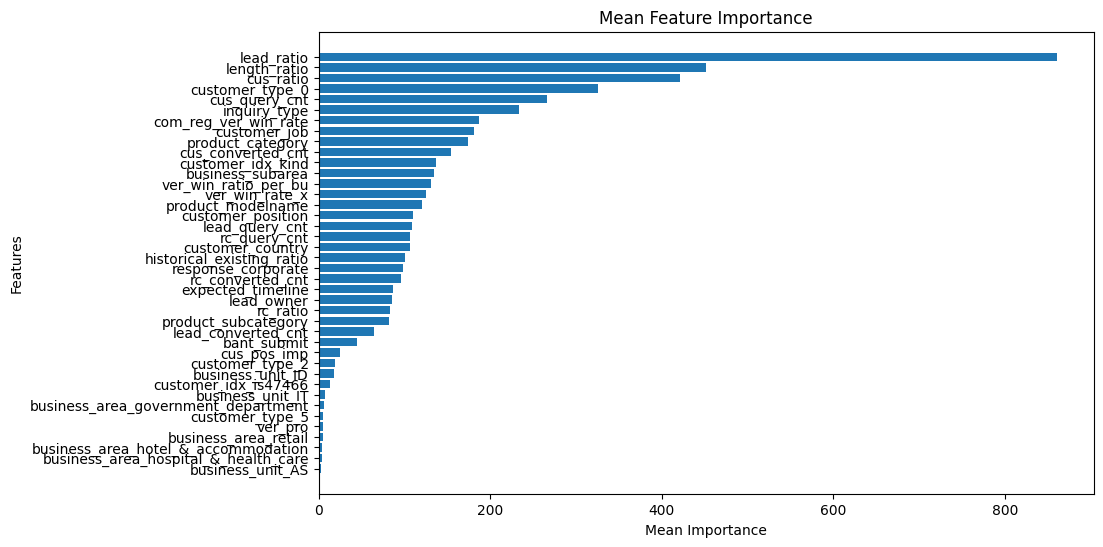

In [530]:
# 특징 중요도와 특징 이름을 정렬
top_features = 40
sorted_indices = np.argsort(-np.mean(feature_importance_lgb_list, axis=0))[::-1]
sorted_feature_names = [lgb_model.feature_name()[i] for i in sorted_indices][-top_features:]
sorted_mean_importance = np.mean(feature_importance_lgb_list, axis=0)[sorted_indices][-top_features:]

# 바 차트 그리기
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_mean_importance)
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.title('Mean Feature Importance')
plt.show()

### 테스트 데이터 예측

In [531]:
oof_test_preds = oof_lgb_test_preds

In [536]:
# 예측에 필요한 데이터 분리
test_pred = np.where(oof_test_preds >= 0.3, 1, 0)

In [537]:
sum(test_pred) # True로 예측된 개수 1038

2187

## 4. 제출하기

### 제출 파일 작성

In [538]:
df_test["is_converted"] = test_pred

C:\Users\baseoki\AppData\Local\Temp\ipykernel_5484\2136695156.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["is_converted"] = test_pred


In [539]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"]=df_test["is_converted"]

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**